# Extending Fastchange

Fastchange is designed to be extendible. Currently there are a few needed arguments due to using Numba for the JIT compilation, so here we provide an example of creating the segmentation, cost, and penalty components of our change point detection method. We will reimplement the `AmocSeg`, `NormalMeanCost`, and `bic_penalty` objects from Fastchange and test it on some synthetic data.

## Importing base classes

To extend Fastchange we are going to subclass the BaseSeg and BaseCost classes. See the imports below for accessing these:

In [1]:
# Importing packages
import numpy as np
import matplotlib.pyplot as plt

from fastchange.seg.base import BaseSeg
from fastchange.costs.base import BaseCost

## Writing our segmentation class

The first think we are going to define is our segmentation algorithm, which in this case is the at-most one change point method. This is essentially just an exhaustive search for the best change point index and comparing it to the cost of no change point. We need to define a single static method called seg_fn with the given arguments (see the docs for what these mean). You will see why we use a static method in the JIT compilation section of this page. Note our seg_fn method should return an array of changepoints. If no change point is detected we will return an empty array.

In [2]:
class AmocSeg(BaseSeg):
    
    @staticmethod
    def seg_fn(cost, sumstats, cost_args, penalty, min_len, max_cps, n):
    
        # Getting null cost of no change point
        null_cost = cost(0, n, sumstats, cost_args)
        
        # Iterating through change point candidates
        costs = np.empty(n - 2 * min_len, dtype=np.float64)
        for i in range(min_len, n - min_len):
            
            # Cost of segment before change point
            pre_cost = cost(0, i, sumstats, cost_args)
            
            # Cost of segment after change point
            post_cost = cost(i, n, sumstats, cost_args)
            
            # Total cost
            costs[i - min_len] = pre_cost + post_cost + penalty
            
        # Finding best change point
        best_ind = np.argmin(costs)
        if costs[best_ind] < null_cost:
            cp = np.int64([best_ind + min_len])
        else:
            cp = np.int64([-1])
            
        return cp

## Writing our cost class

Now we are going to declare our cost function class, which will be used to evaluate how homogeneous a segment is. In this case we are implementing the normal mean cost, which will calculate the normal distribution-based likelihood of a location shift. We need to define two static methods here: preprocess and cost_fn. The preprocess method returns an array of time-index summary statistics used to calculate the cost and an array of float values which can be used to pass arguments to the cost calculation. Our cost_fn method takes four arguments, the start+end indices of a proposed segment, the summary statistics, and an optional array of floats from the preprocess method. The class attribute n_params signifies how many parameters we are estimating in our cost function, which is this case is the normal mean. This attribute is used by our scalar penalty function.

In [3]:
# Recreating our normal mean cost
import math

class NormalMeanCost(BaseCost):
    
    n_params = 1
    
    @staticmethod
    def preprocess(y, args):
        sumstats = np.empty((y.shape[0] + 1, 2), np.float64)
        sumstats[0, :] = 0.0
        sumstats[1:, 0] = y.cumsum()
        sumstats[1:, 1] = (y ** 2).cumsum()

        return sumstats, np.float64([0.0])
    
    @staticmethod
    def cost_fn(s, e, y, cost_args):
        n = e - s
        d1 = y[e, 0] - y[s, 0]
        d2 = y[e, 1] - y[s, 1]
        return d2 - math.pow(d1, 2) / n

## Writing our penalty function

Lastly we are going to write a function to penalize the number of change points in our model. Here we will implement the common Bayes information criterion.

In [4]:
def bic_penalty(n, n_params):
    return (n_params + 1) * math.log(n)

## Testing it all out

We are going to test our change point components on a synthetic time series:

In [5]:
# Creating synthetic data
data = np.hstack([
    np.random.normal(0, 1, (1000,)),
    np.random.normal(5, 2, (1000,))
])

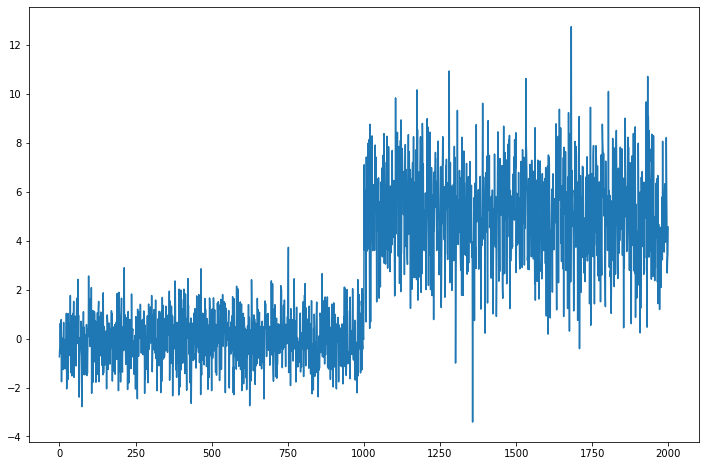

In [6]:
# Plotting our synthetic data
plt.figure(figsize=(12, 8))
plt.plot(data)
plt.show()

In [7]:
# Running AMOC changepoint
model = AmocSeg(NormalMeanCost(), bic_penalty).fit(data)
cpts = model.predict()

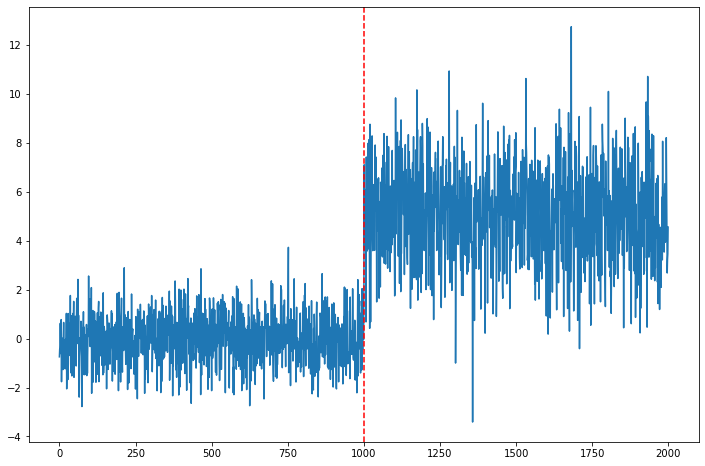

In [8]:
# Plotting our synthetic data with detected change points
plt.figure(figsize=(12, 8))
plt.plot(data)
for i in cpts:
    plt.axvline(i, color='red', linestyle='--')
plt.show()

From the plot above, we can see that our setup does a pretty good job of identifying the change point!

## JIT Compilation with Numba

While our classes defined above do a good job of detecting the change point in our artificial time-series, we likely want to leverage Numba to get a big performance boost. First, we will benchmark our current change point code, and from the cell below we can see it takes on average 5.45 milliseconds.

In [9]:
%timeit AmocSeg(NormalMeanCost(), bic_penalty).fit(data).predict()

5.45 ms ± 92.5 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


We are going to use the awesome Numba package to compile our code on the fly by using a simple function decorator. In the cells below we can see the Numbafied code, which uses the `njit` decorator with some predefined function signatures from Fastchange. Numba can't be used on instance methods utilizing self, hence why we need to use `@staticmethod` to define our functions.

Numba will compile our function at declare time as we have declared the function signature ahead of time, and cache the resulting compiled code will be cached on the host filesystem for faster loading later.

In [10]:
# Importing additional objects for Numba
import numba as nb

from fastchange.seg.base import seg_sig
from fastchange.costs.base import preprocess_sig, cost_sig

In [11]:
class AmocSeg(BaseSeg):
    
    @staticmethod
    @nb.njit(seg_sig(), fastmath=True)
    def seg_fn(cost, sumstats, cost_args, penalty, min_len, max_cps, n):
    
        # Getting null cost of no change point
        null_cost = cost(0, n, sumstats, cost_args)
        
        # Iterating through change point candidates
        costs = np.empty(n - 2 * min_len, dtype=np.float64)
        for i in range(min_len, n - min_len):
            
            # Cost of segment before change point
            pre_cost = cost(0, i, sumstats, cost_args)
            
            # Cost of segment after change point
            post_cost = cost(i, n, sumstats, cost_args)
            
            # Total cost
            costs[i - min_len] = pre_cost + post_cost + penalty
            
        # Finding best change point
        best_ind = np.argmin(costs)
        if costs[best_ind] < null_cost:
            cp = np.int64([best_ind + min_len])
        else:
            cp = np.int64([-1])
            
        return cp

In [12]:
# Recreating our normal mean cost
class NormalMeanCost(BaseCost):
    
    n_params = 1
    
    @staticmethod
    @nb.njit(preprocess_sig, fastmath=True)
    def preprocess(y, args):
        sumstats = np.empty((y.shape[0] + 1, 2), np.float64)
        sumstats[0, :] = 0.0
        sumstats[1:, 0] = y.cumsum()
        sumstats[1:, 1] = (y ** 2).cumsum()

        return sumstats, np.float64([0.0])
    
    @staticmethod
    @nb.njit(cost_sig, fastmath=True)
    def cost_fn(s, e, y, cost_args):
        n = e - s
        d1 = y[e, 0] - y[s, 0]
        d2 = y[e, 1] - y[s, 1]
        return d2 - math.pow(d1, 2) / n

In [13]:
# Running AMOC changepoint
model = AmocSeg(NormalMeanCost(), bic_penalty).fit(data)
cpts = model.predict()

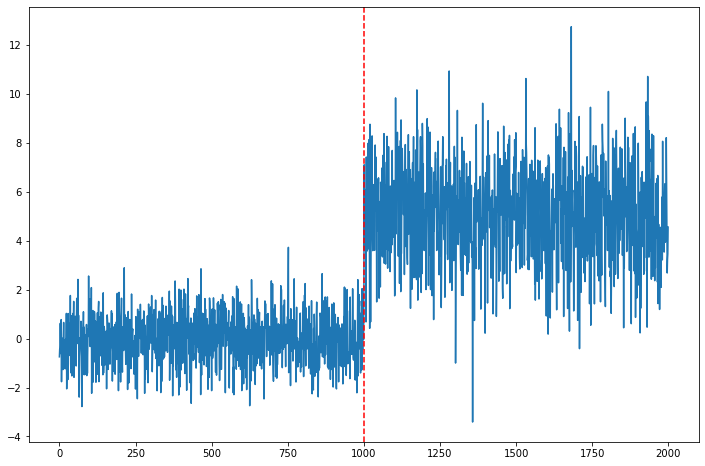

In [14]:
# Plotting our synthetic data with detected change points
plt.figure(figsize=(12, 8))
plt.plot(data)
for i in cpts:
    plt.axvline(i, color='red', linestyle='--')
plt.show()

In [15]:
%timeit AmocSeg(NormalMeanCost(), bic_penalty).fit(data).predict()

141 µs ± 4.57 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


Wow, looks like the Numba-based code is almost 40 times faster than pure Python! There are definitely some more optimizations we could make, such as parallelizing our inner loop in `AmocSeg` and checking for SIMD vectorization, but this is a good example of how Numba can be leveraged for some fast performance gains.